In [1]:
# Clipped and compressed DEM (less computation)

from pysheds.grid import Grid

grid = Grid.from_raster(r'data-inputs\\USGS.tif')
dem = grid.read_raster(r'data-inputs\\USGS.tif')

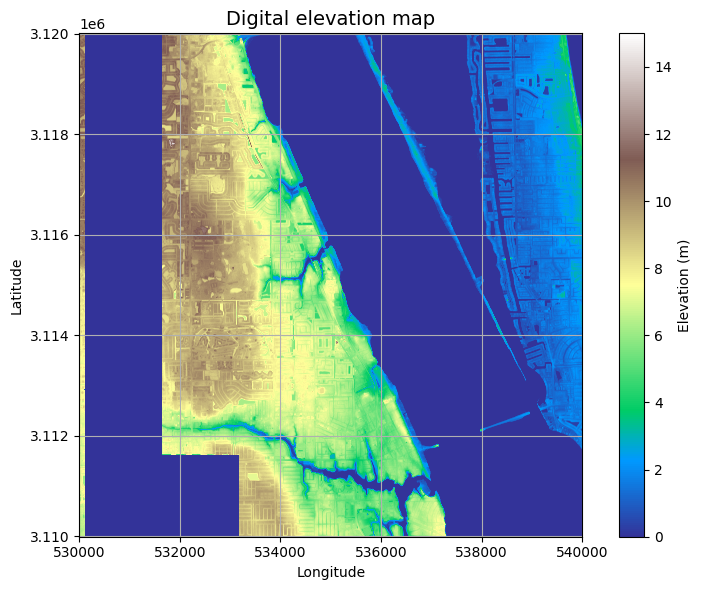

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Define the normalization for the elevation between 0 and 15 meters
norm = colors.Normalize(vmin=0, vmax=15)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

# Plot the DEM with normalization applied
plt.imshow(dem, extent=grid.extent, cmap='terrain', norm=norm, zorder=1)
#plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [3]:

pit_filled_dem = grid.fill_pits(dem)

flooded_dem = grid.fill_depressions(pit_filled_dem)
    

inflated_dem = grid.resolve_flats(flooded_dem)

print(inflated_dem.dtype)


dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# fdir = grid.flowdir(inflated_dem, dirmap=dirmap, nodata_out=np.int64(0))

fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

float64


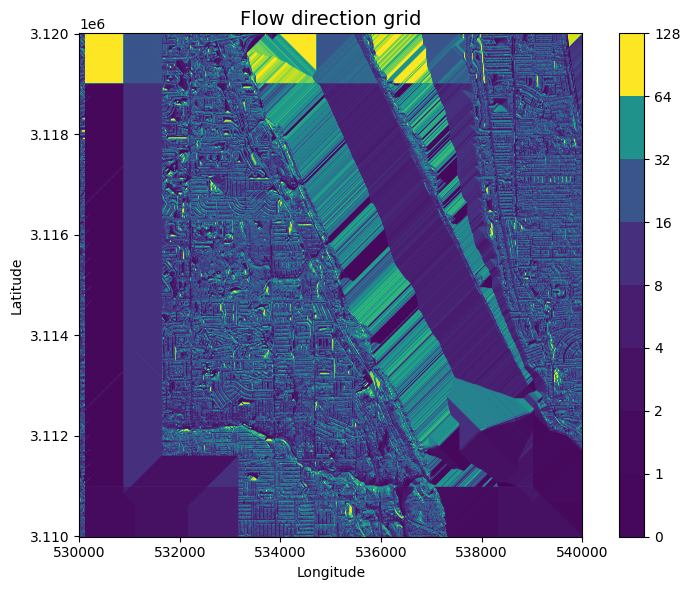

In [4]:
#unproj dem
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

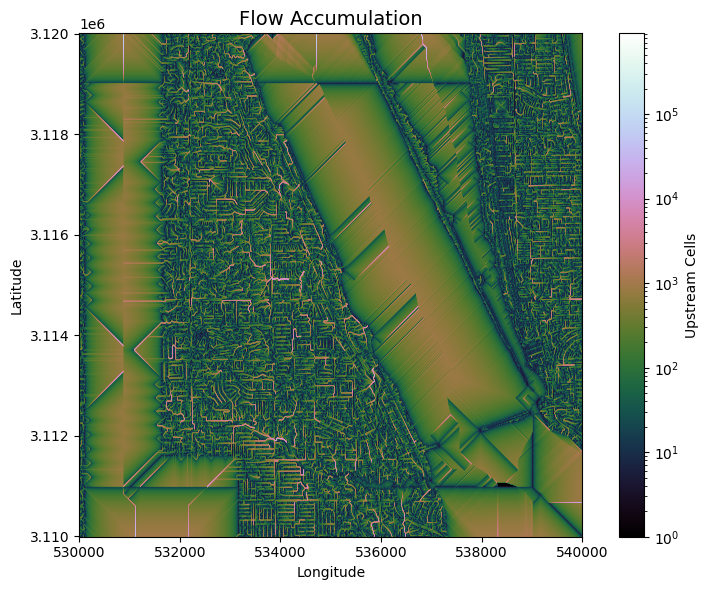

In [5]:
#unproj dem
acc = grid.accumulation(fdir, dirmap=dirmap)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
# ponds.plot()
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [ ]:
# Read ponds shapefile
import pandas as pd
import geopandas as gpd
from shapely import geometry, ops
ponds = gpd.read_file(r'data-inputs\\IRL-Ponds-Export\\IRL-Ponds-Export_NAD83.shp')
# print(ponds.head())


In [6]:
# Alden: this step always crashes my kernel when using the USGS.tif... I should look into that limits if it's a computatio limit

# Joe's point - USGS tif
x, y = 534750, 3.114
# x, y = 534000, 3.117

# Scalgo7 point
# x, y = 533300, 3.121

x_snap, y_snap = grid.snap_to_mask(acc > 50000, (x, y)) #250000

catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')


grid.clip_to(catch)
clipped_catch = grid.view(catch)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(catch, catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

: 

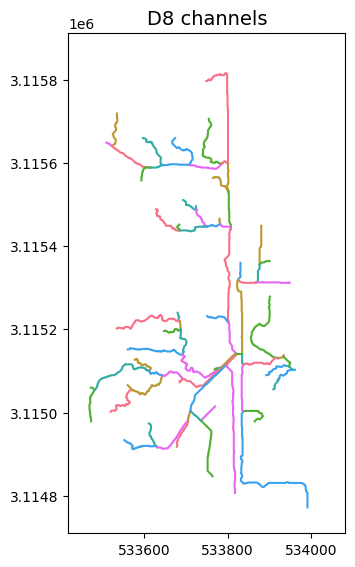

In [159]:
# unprojected DEM
branches = grid.extract_river_network(fdir, acc > 2000, dirmap=dirmap,  nodata_out=np.int64(0))

sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

In [160]:
# Find the junctions in the river network

from collections import defaultdict
import numpy as np


node_counts = defaultdict(int)

precision = 10


for branch in branches['features']:
    
    line = np.asarray(branch['geometry']['coordinates'])
    
    
    for point in line:
       
        rounded_point = tuple(np.round(point, precision))
        node_counts[rounded_point] += 1

junctions = [node for node, count in node_counts.items() if count > 1]

print(f"Junction points: {junctions}")

Junction points: [(533801.0, 3115599.0), (533523.0, 3115641.0), (533787.0, 3115599.0), (533642.0, 3115596.0), (533712.0, 3115595.0), (533615.0, 3115589.0), (533802.0, 3115532.0), (533808.0, 3115441.0), (533725.0, 3115488.0), (533750.0, 3115447.0), (533685.0, 3115438.0), (533782.0, 3115452.0), (533802.0, 3115217.0), (533877.0, 3115356.0), (533868.0, 3115313.0), (533825.0, 3115318.0), (533835.0, 3115140.0), (533922.0, 3115131.0), (533685.0, 3115219.0), (533822.0, 3115141.0), (533687.0, 3115200.0), (533691.0, 3115139.0), (533779.0, 3115107.0), (533934.0, 3115135.0), (533612.0, 3115100.0), (533784.0, 3115108.0), (533949.0, 3115110.0), (533923.0, 3115081.0), (533692.0, 3115081.0), (533572.0, 3115054.0), (533480.0, 3115055.0), (533955.0, 3115104.0), (533736.0, 3114981.0), (533644.0, 3115089.0), (533821.0, 3115140.0), (533837.0, 3115004.0), (533631.0, 3114917.0), (533705.0, 3114981.0), (533711.0, 3115004.0), (533799.0, 3115117.0), (533839.0, 3115116.0)]


C:\Users\alden.summerville\AppData\Local\Temp\ipykernel_30180\3214414384.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20b', len(junctions))


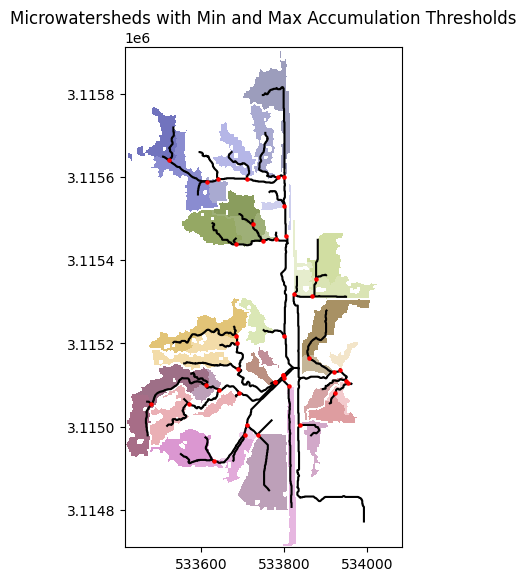

In [161]:
#unproj DEM
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a figure for plotting all catchments
plt.figure(figsize=(8.5, 6.5))

# Set the plot boundaries and aspect ratio
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
plt.gca().set_aspect('equal')

# Define colormap for unique catchment colors
colors = plt.cm.get_cmap('tab20b', len(junctions))

# Define the minimum and maximum accumulation thresholds
min_acc = 1000
max_acc = 20000

# Loop over each junction and plot its catchment
for i, junction in enumerate(junctions):
    x, y = junction
    
    # Snap the junction to the nearest cell where accumulation is between min_acc and max_acc
    mask = (acc > min_acc) & (acc < max_acc)
    x_snap, y_snap = grid.snap_to_mask(mask, (x, y))
    
    # Delineate the catchment for the snapped point
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')
    
    # Plot the catchment with a unique color
    plt.imshow(np.where(catch, catch, np.nan), extent=grid.extent, cmap=mcolors.ListedColormap([colors(i)]), alpha=0.5)

# Plot the river network on top of the catchments
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1], color='black')

# Highlight all junction points
for junction in junctions:
    x, y = junction
    x_snap, y_snap = grid.snap_to_mask(mask, (x, y))
    plt.scatter(x_snap, y_snap, color='red', s=5, zorder=5)

# Add title and show the combined plot
plt.title('Microwatersheds with Min and Max Accumulation Thresholds')
plt.show()


C:\Users\alden.summerville\AppData\Local\Temp\ipykernel_30180\1215946809.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(junctions))  # Use a colormap that supports many discrete colors


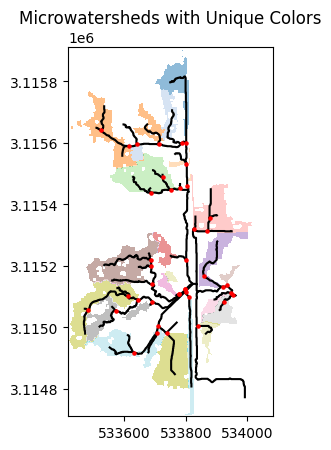

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Set the plot boundaries and aspect ratio
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
plt.gca().set_aspect('equal')

# Define colormap for unique catchment colors
colors = plt.cm.get_cmap('tab20', len(junctions))  # Use a colormap that supports many discrete colors

# Define the minimum and maximum accumulation thresholds
min_acc = 1000
max_acc = 20000

# Create an empty array to store the combined catchment mask
# Use integers to assign a different number for each catchment
combined_catchment = np.zeros(grid.shape, dtype=int)

# Loop over each junction and plot its catchment with a unique color
for i, junction in enumerate(junctions):
    x, y = junction
    
    # Snap the junction to the nearest cell where accumulation is between min_acc and max_acc
    mask = (acc > min_acc) & (acc < max_acc)
    x_snap, y_snap = grid.snap_to_mask(mask, (x, y))
    
    # Delineate the catchment for the snapped point
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')
    
    # Assign a unique integer value for each catchment
    combined_catchment[catch] = i + 1  # Start numbering catchments from 1
    
# Plot the combined catchments with a unique color for each
# Use a discrete colormap
plt.imshow(np.where(combined_catchment > 0, combined_catchment, np.nan), extent=grid.extent, cmap=colors, alpha=0.5)

# Plot the river network on top of the combined catchments
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1], color='black')

# Highlight all junction points
for junction in junctions:
    x, y = junction
    x_snap, y_snap = grid.snap_to_mask(mask, (x, y))
    plt.scatter(x_snap, y_snap, color='red', s=5, zorder=5)

# Add title and show the combined plot
plt.title('Microwatersheds with Unique Colors')
plt.show()
